# Multiclass Lift and Gain Plots
Vinicius Trevisan 2022

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Functions

In [3]:
def plot_lift(y_real, y_proba, ax = None, color = 'b', title = 'Lift Curve', plot_guide = False):
    # Prepare the data
    aux_df = pd.DataFrame()
    aux_df['y_real'] = y_real
    aux_df['y_proba'] = y_proba
    # Sort by predicted probability
    aux_df = aux_df.sort_values('y_proba', ascending = False)
    # Find the total positive ratio of the whole dataset
    total_positive_ratio = sum(aux_df['y_real'] == 1) / aux_df.shape[0]
    # For each line of data, get the ratio of positives of the given subset and calculate the lift
    lift_values = []
    for i in aux_df.index:
        threshold = aux_df.loc[i]['y_proba']
        subset = aux_df[aux_df['y_proba'] >= threshold]
        subset_positive_ratio = sum(subset['y_real'] == 1) / subset.shape[0]
        lift = subset_positive_ratio / total_positive_ratio
        lift_values.append(lift)
    # Plot the lift curve
    if ax == None:
        ax = plt.axes()
    ax.set_xlabel('Proportion of sample')
    ax.set_ylabel('Lift')
    ax.set_title(title)
    sns.lineplot(x = [x/len(lift_values) for x in range(len(lift_values))], y = lift_values, ax = ax, color = color)
    if plot_guide:
        ax.axhline(1, color = 'gray', linestyle = 'dashed', linewidth = 3)

In [4]:
def plot_gain(y_real, y_proba, ax = None, color = 'b', title = 'Gain Curve', plot_guide = False):
    # Prepares the data
    aux_df = pd.DataFrame()
    aux_df['y_real'] = y_real
    aux_df['y_proba'] = y_proba
    # Sorts by predicted probability
    aux_df = aux_df.sort_values('y_proba', ascending = False)
    # Finds the total number of positive classes on the dataset
    total_positive_count = sum(aux_df['y_real'] == 1)
    # For each line of data, check if it is positive, add to the counter and calculate the gain
    gain = 0
    subset_positive_count = 0
    gain_values = []
    for i in aux_df.index:
        if aux_df.loc[i]['y_real'] == 1:
            subset_positive_count += 1
        gain = subset_positive_count / total_positive_count
        gain_values.append(gain)
    # Plots the gain curve
    if ax == None:
        ax = plt.axes()
    ax.set_xlabel('Proportion of sample')
    ax.set_ylabel('Gain')
    ax.set_title(title)
    sns.lineplot(x = [x/len(gain_values) for x in range(len(gain_values))], y = gain_values, ax = ax, color = color)
    if plot_guide:
        sns.lineplot(x = [0, 1], y = [0,1], color = 'gray', linestyle = 'dashed', linewidth = 1, ax = ax)

## Multiclass classification evaluation with KS test

### Creating a synthetic dataset

In [5]:
scale = 3.5
size = 1000

In [6]:
class1_x = np.random.normal(loc = 10, scale = scale, size = size)
class1_y = np.random.normal(loc = 1, scale = scale, size = size)

In [7]:
class2_x = np.random.normal(loc = 1, scale = scale, size = size)
class2_y = np.random.normal(loc = 5, scale = scale, size = size)

In [8]:
class3_x = np.random.normal(loc = 10, scale = scale, size = size)
class3_y = np.random.normal(loc = 10, scale = scale, size = size)

In [9]:
df_class1 = pd.DataFrame({'x' : class1_x, 'y' : class1_y, 'class': 'apple'})
df_class2 = pd.DataFrame({'x' : class2_x, 'y' : class2_y, 'class': 'banana'})
df_class3 = pd.DataFrame({'x' : class3_x, 'y' : class3_y, 'class': 'orange'})
df = df_class1.append(df_class2, ignore_index = True)
df = df.append(df_class3, ignore_index = True)

<AxesSubplot:xlabel='x', ylabel='y'>

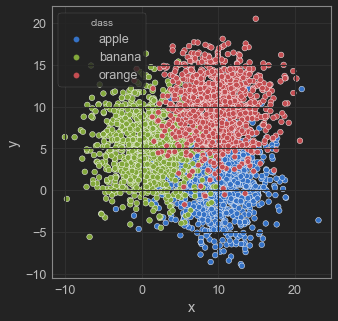

In [10]:
# Plot them to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'x', y = 'y', hue = 'class', data = df)

In [11]:
X = df[['x', 'y']]
y = df['class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fits the model and make the predictions

In [13]:
model_multiclass = GaussianNB()
# model_multiclass = RandomForestClassifier(n_estimators = 50, criterion = 'gini')
# model_multiclass = XGBClassifier()

In [14]:
model_multiclass.fit(X_train, y_train)

GaussianNB()

In [15]:
y_pred = model_multiclass.predict(X_test)

In [16]:
y_proba = model_multiclass.predict_proba(X_test)

## One vs Rest (OvR)
Compares each class with the rest of the classes

In [17]:
classes = model_multiclass.classes_
classes

array(['apple', 'banana', 'orange'], dtype='<U6')

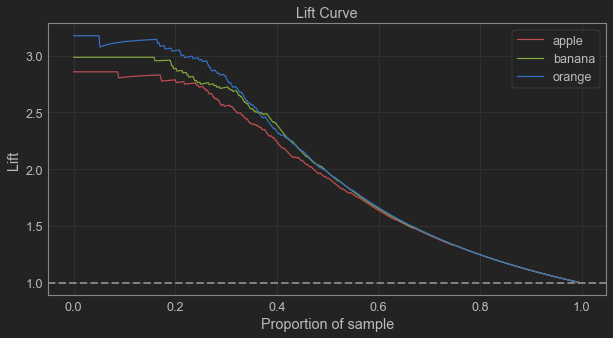

In [18]:
# Plots lift OvR
plt.figure(figsize = (10, 5))
ax = plt.axes()
colors = ['r', 'g', 'b']

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)  
    # Plots the lift
    plot_lift(df_aux['class'], df_aux['prob'], ax = ax, color = colors[i], plot_guide = False)

ax.axhline(1, color = 'gray', linestyle = 'dashed', linewidth = 2)
plt.legend(classes)

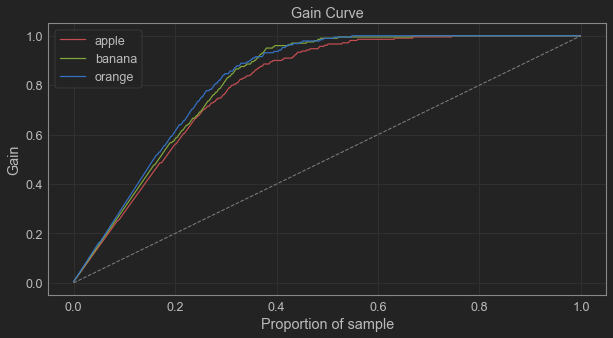

In [19]:
# Plots Gain OvR
plt.figure(figsize = (10, 5))
ax = plt.axes()
colors = ['r', 'g', 'b']

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)  
    # Plots the lift
    plot_gain(df_aux['class'], df_aux['prob'], ax = ax, color = colors[i], plot_guide = False)
    
sns.lineplot(x = [0, 1], y = [0,1], color = 'gray', linestyle = 'dashed', linewidth = 1, ax = ax)
plt.legend(classes)

## One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [20]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['apple', 'banana'],
 ['banana', 'apple'],
 ['apple', 'orange'],
 ['orange', 'apple'],
 ['banana', 'orange'],
 ['orange', 'banana']]

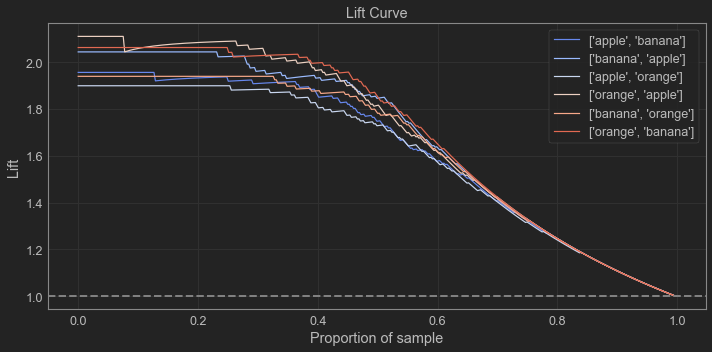

In [21]:
# Plots the Lift Curves for each combination of two distinct classes
plt.figure(figsize = (10, 5))
ax = plt.axes()
bins = [i/20 for i in range(20)] + [1]
ks_ovo = {}
colors = sns.color_palette('coolwarm')[:len(classes_combinations)]

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " + c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    plot_lift(df_aux['class'], df_aux['prob'], ax = ax, color = colors[i], plot_guide = False)
    

ax.axhline(1, color = 'gray', linestyle = 'dashed', linewidth = 2)
plt.legend(classes_combinations)
plt.tight_layout()

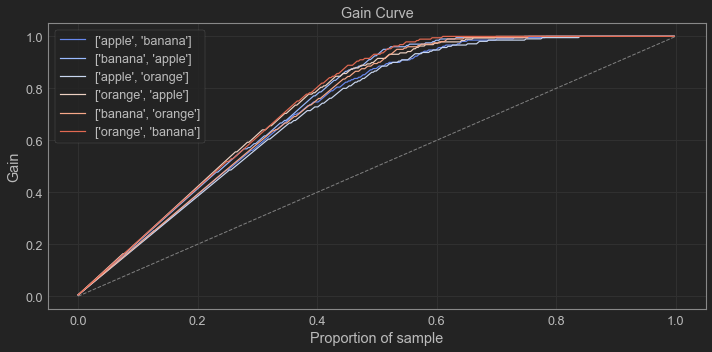

In [22]:
# Plots the Gain Curves for each combination of two distinct classes
plt.figure(figsize = (10, 5))
ax = plt.axes()
bins = [i/20 for i in range(20)] + [1]
ks_ovo = {}
colors = sns.color_palette('coolwarm')[:len(classes_combinations)]

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " + c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    plot_gain(df_aux['class'], df_aux['prob'], ax = ax, color = colors[i], plot_guide = False)
    

sns.lineplot(x = [0, 1], y = [0,1], color = 'gray', linestyle = 'dashed', linewidth = 1, ax = ax)
plt.legend(classes_combinations)
plt.tight_layout()